In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


In [40]:

def preprocessing(data_name, sheet_num):
    """
    param data_name: The title of the data that will be used in any figure title.
    param sheet_num: The sheet number; the excel file contains many sheets.
    
    This function will read the data in the file (2020Q1Q2Q3Q4-2021Q1.xlsx) and return a clean df.
    """
    # read the file
    xls = pd.ExcelFile('../data/2020Q1Q2Q3Q4-2021Q1.xlsx')
    # read the sheet
    df = xls.parse(sheet_num)
    # print the head of the df
    print(f'The first 5 rows of the {data_name} data set: \n\n{df.head()}\n')
    print('*' * 110)
    # remove the laast row; contains a text
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Fixing the Vol columns by converting the k-values to M by dividing by 1000 and convert the column data type into int
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    df = pd.concat([df, k_data], join="inner")
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    # make the index equal to Date values
    df = df.set_index('Date')
    df = df.sort_values(by=['Date'], ascending=True)

    
    return df, data_name

In [41]:
df, data_name = preprocessing('Russia',  0)
df

The first 5 rows of the Russia data set: 

                  Date   Price    Open    High     Low    Vol.  Change %
0  2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
1  2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
2  2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
3  2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
4  2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030

**************************************************************************************************************


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071


<Figure size 640x480 with 0 Axes>

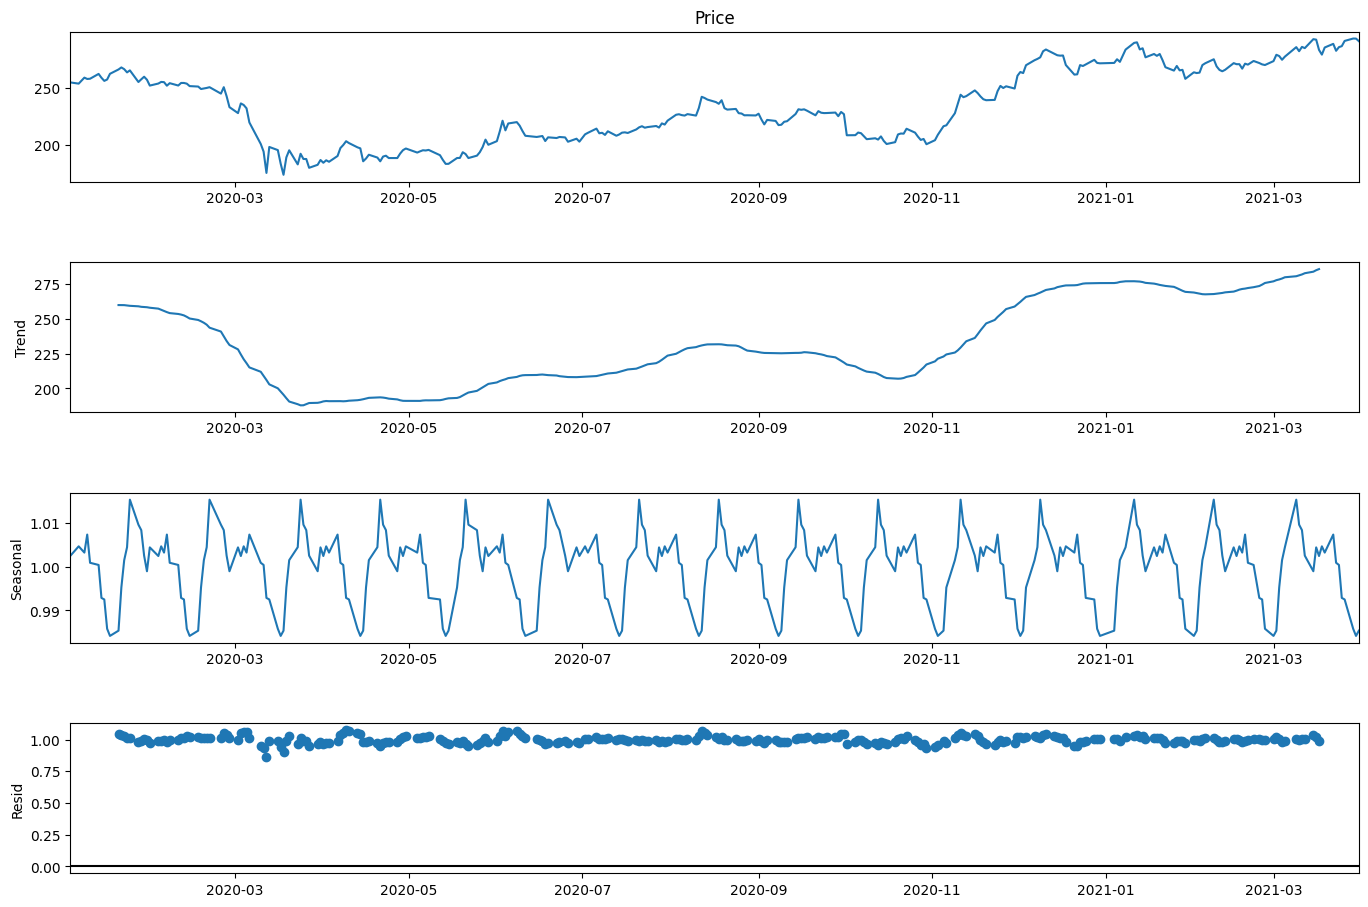

In [42]:
result = seasonal_decompose(df['Price'], model='multiplicative',period=20) 
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

In [43]:
def test_stationarity(timeseries):
        #Determing rolling statistics
        rolmean = timeseries.rolling(6).mean()
        rolstd = timeseries.rolling(6).std()
        #Plot rolling statistics:
        plt.grid(True)
        plt.plot(timeseries, color='blue',label='Original')
        plt.plot(rolmean, color='red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.show(block=False)
        print("Results of dickey fuller test")
        adft = adfuller(timeseries,autolag='AIC')
        # output for dft will give us without defining what the values are.
        #hence we manually write what values does it explains using a for loop
        output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
        for key,values in adft[4].items():
            output['critical value (%s)'%key] =  values
        print(output)

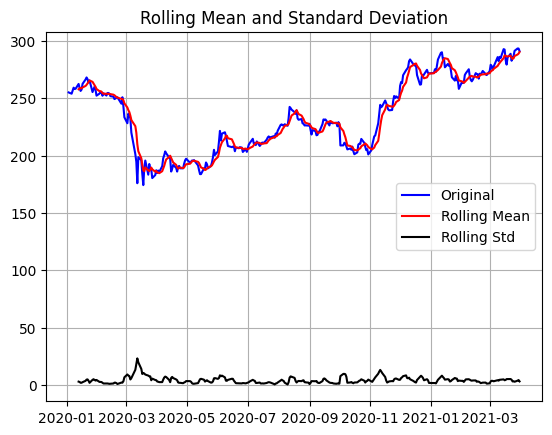

Results of dickey fuller test
Test Statistics                 -0.986360
p-value                          0.758207
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [44]:
test_stationarity(df['Price'])

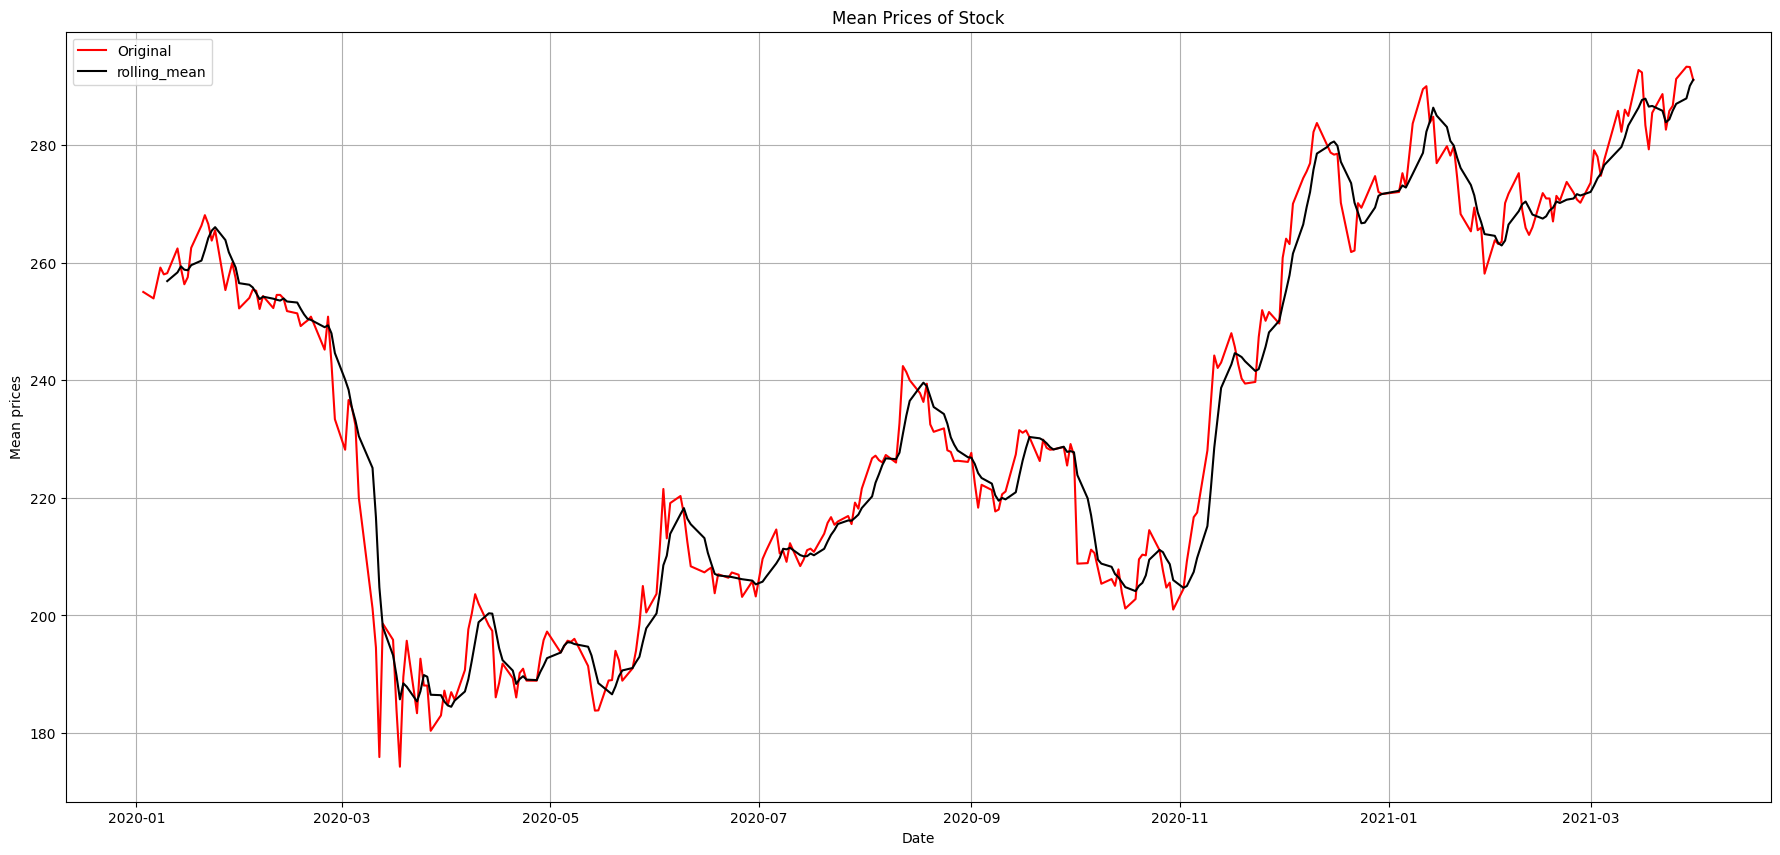

In [45]:
# Moving average method
moving_avg = df['Price'].rolling(5).mean()
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(df['Price'], color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "rolling_mean")
plt.title("Mean Prices of Stock")
plt.xlabel("Date")
plt.ylabel("Mean prices")
plt.legend()
plt.show()

In [46]:
ts_moving_avg_diff = df['Price'] - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

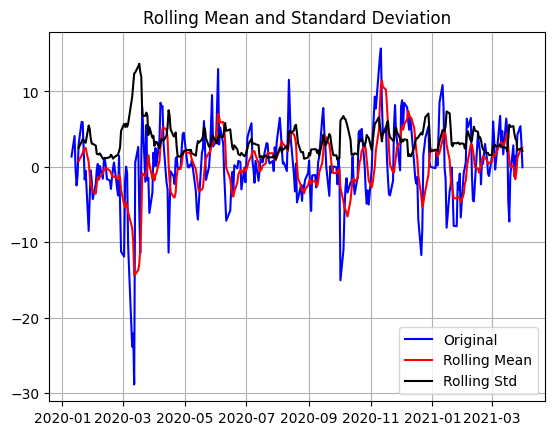

Results of dickey fuller test
Test Statistics               -8.157246e+00
p-value                        9.348057e-13
No. of lags used               1.000000e+00
Number of observations used    3.050000e+02
critical value (1%)           -3.451974e+00
critical value (5%)           -2.871063e+00
critical value (10%)          -2.571844e+00
dtype: float64


In [47]:
test_stationarity(ts_moving_avg_diff)

In [48]:
df['difference'] = ts_moving_avg_diff
df['difference'].fillna(df['difference'].mean(), inplace=True)


In [49]:
df['Date'] = df.index
df = df.reset_index(drop=True)
df

,Price,Open,High,Low,Vol.,Change %,difference,Date
0,255.00,255.99,258.19,253.70,35.85,0.0010,0.227648,2020-01-03
1,253.90,254.75,254.84,251.40,22.35,-0.0043,0.227648,2020-01-06
2,259.15,253.57,259.15,253.03,40.82,0.0207,0.227648,2020-01-08
3,257.99,259.40,261.76,257.01,38.33,-0.0045,0.227648,2020-01-09
4,258.19,257.86,259.25,256.88,18.85,0.0008,1.344000,2020-01-10
...,...,...,...,...,...,...,...,...
306,286.66,286.50,287.03,283.85,35.22,0.0030,0.826000,2021-03-25
307,291.22,288.63,292.75,288.32,56.07,0.0159,4.236000,2021-03-26
308,293.30,289.72,294.09,289.26,43.68,0.0071,5.386000,2021-03-29
309,293.25,294.86,295.72,291.50,38.81,-0.0002,3.206000,2021-03-30


In [50]:
train_data_prophet = df[['difference', 'Date']][0:250]
test_data_prophet = df[['difference', 'Date']][250:]

In [51]:
train_data_prophet.rename(columns={"Date": "ds", "difference": "y"}, inplace=True)
train_data_prophet

,y,ds
0,0.227648,2020-01-03
1,0.227648,2020-01-06
2,0.227648,2020-01-08
3,0.227648,2020-01-09
4,1.344000,2020-01-10
...,...,...
245,2.638000,2020-12-24
246,3.862000,2020-12-25
247,5.340000,2020-12-28
248,0.648000,2020-12-29


In [52]:
test_data_prophet.rename(columns={"Date": "ds", "difference": "y"}, inplace=True)
test_data_prophet

,y,ds
250,-0.198,2021-01-04
251,2.090,2021-01-05
252,0.174,2021-01-06
253,8.556,2021-01-08
254,10.838,2021-01-11
...,...,...
306,0.826,2021-03-25
307,4.236,2021-03-26
308,5.386,2021-03-29
309,3.206,2021-03-30


16:13:55 - cmdstanpy - INFO - Chain [1] start processing
16:13:55 - cmdstanpy - INFO - Chain [1] done processing


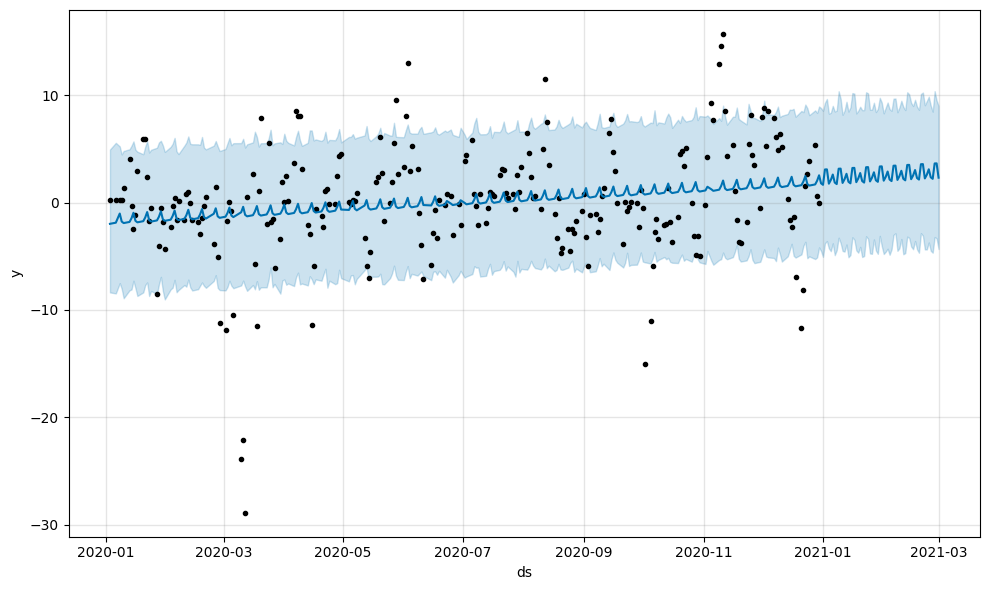

In [53]:

# Instantiate the Prophet class and fit it on the training data
model = Prophet()
model.fit(train_data_prophet)

# Create a new DataFrame with future dates
future = model.make_future_dataframe(periods=len(test_data_prophet))

# Generate forecasts for the future dates
forecast = model.predict(future)

# Plot the actual values and the forecasted values
fig = model.plot(forecast)
plt.show()

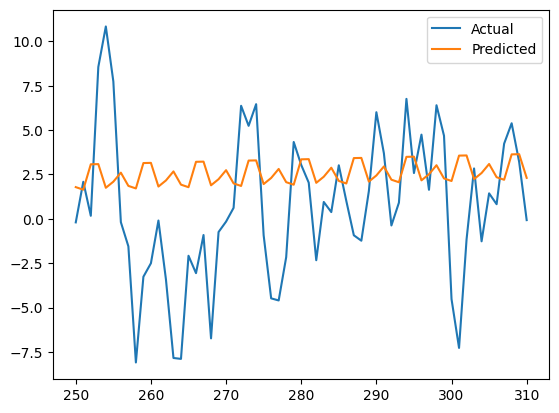

In [54]:
# visualize the predictions vs. the actual values
plt.plot(test_data_prophet.index, test_data_prophet['y'], label='Actual')
plt.plot(test_data_prophet.index, forecast[250:]['yhat'], label='Predicted')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1885.829, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1699.612, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1744.528, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1694.488, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1696.306, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1696.412, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1695.523, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1697.350, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1696.338, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  307
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -844.244
Date:                Sat, 01 Apr 2023   AIC      

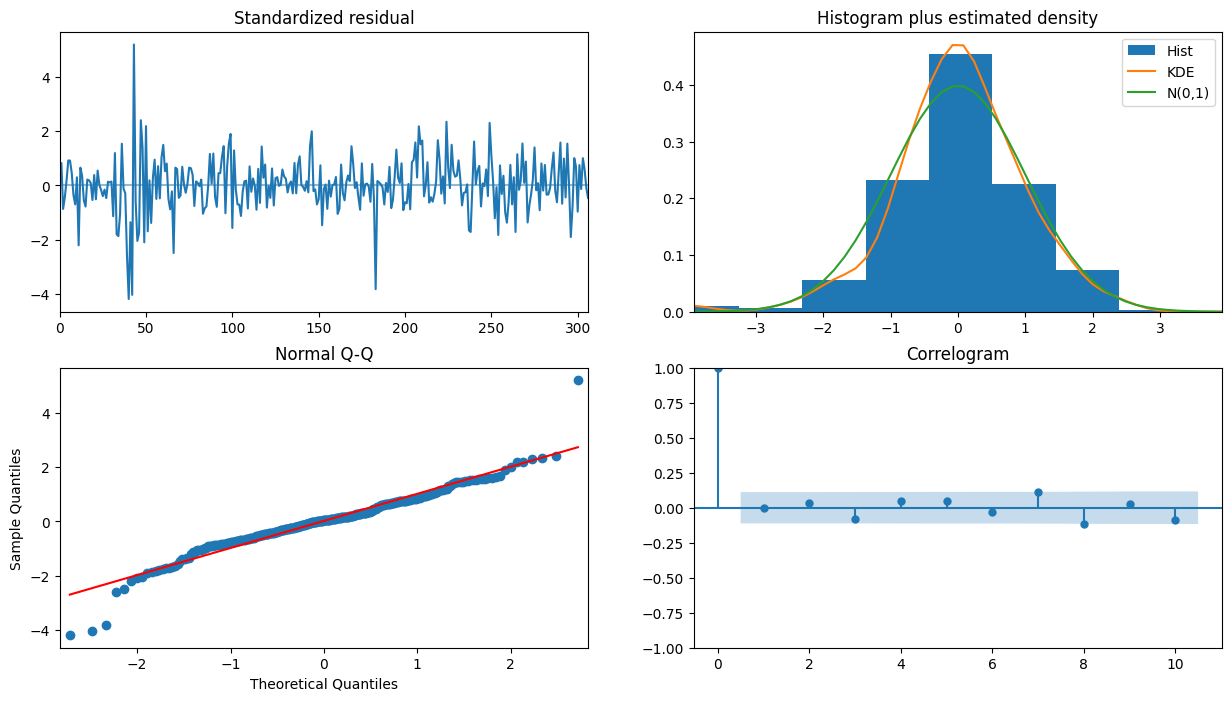

In [55]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(ts_moving_avg_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


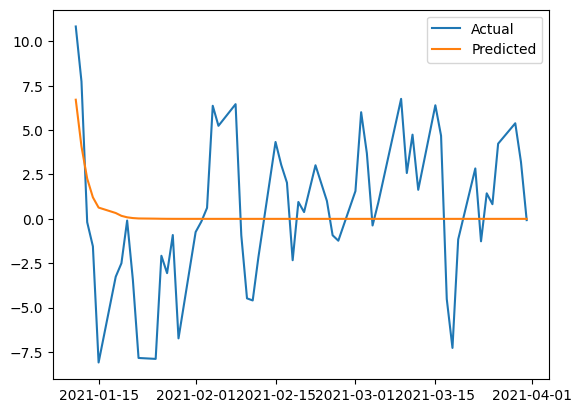

In [56]:
# split data into train and test sets


train_data_auto = ts_moving_avg_diff[:250]
test_data_auto = ts_moving_avg_diff[250:]

# fit the ARIMA model on the training data
model_autoARIMA.fit(train_data_auto)

# make predictions on the test data
predictions = model_autoARIMA.predict(n_periods=len(test_data_auto))

# visualize the predictions vs. the actual values
plt.plot(test_data_auto.index, test_data_auto.values, label='Actual')
plt.plot(test_data_auto.index, predictions, label='Predicted')
plt.legend()
plt.show()


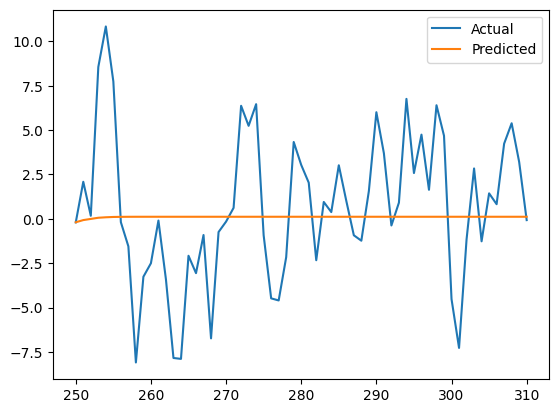

In [57]:
# split data into train and test sets
train_data_arima = df['difference'][:250]
test_data_arima = df['difference'][250:]

# fit an ARIMA model to the difference series
model = ARIMA(train_data_arima, order=(3,0,1))
model_fit = model.fit()

# make predictions on the test data
start_idx = test_data_arima.index[0]  # get the start index of the test data
end_idx = test_data_arima.index[-1]  # get the end index of the test data
predictions = model_fit.predict(start=start_idx, end=end_idx)

# visualize the predictions vs. the actual values
plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(predictions.index, predictions.values, label='Predicted')
plt.legend()
plt.show()


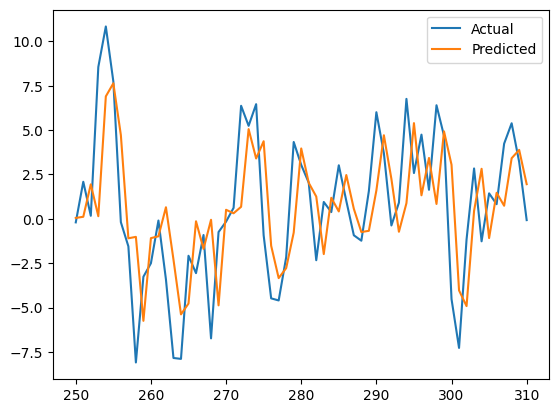

In [58]:

# fit an ARIMA model to the difference series
model = ARIMA(df['difference'], order=(3,1,1))
model_fit = model.fit()

# split data into train and test sets
train_data_arima = df['difference'][:250]
test_data_arima = df['difference'][250:]

# make predictions on the test data
start_idx = test_data_arima.index[0]  # get the start index of the test data
end_idx = test_data_arima.index[-1]  # get the end index of the test data
predictions = model_fit.predict(start=start_idx, end=end_idx)

# visualize the predictions vs. the actual values
plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(predictions.index, predictions.values, label='Predicted')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                  311
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -852.515
Date:                Sat, 01 Apr 2023   AIC                           1715.029
Time:                        16:14:03   BIC                           1733.712
Sample:                             0   HQIC                          1722.498
                                - 311                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7718      0.045     17.047      0.000       0.683       0.861
ar.L2         -0.1330      0.057     -2.314      0.021      -0.246      -0.020
ar.L3         -0.0265      0.041     -0.639      0.5

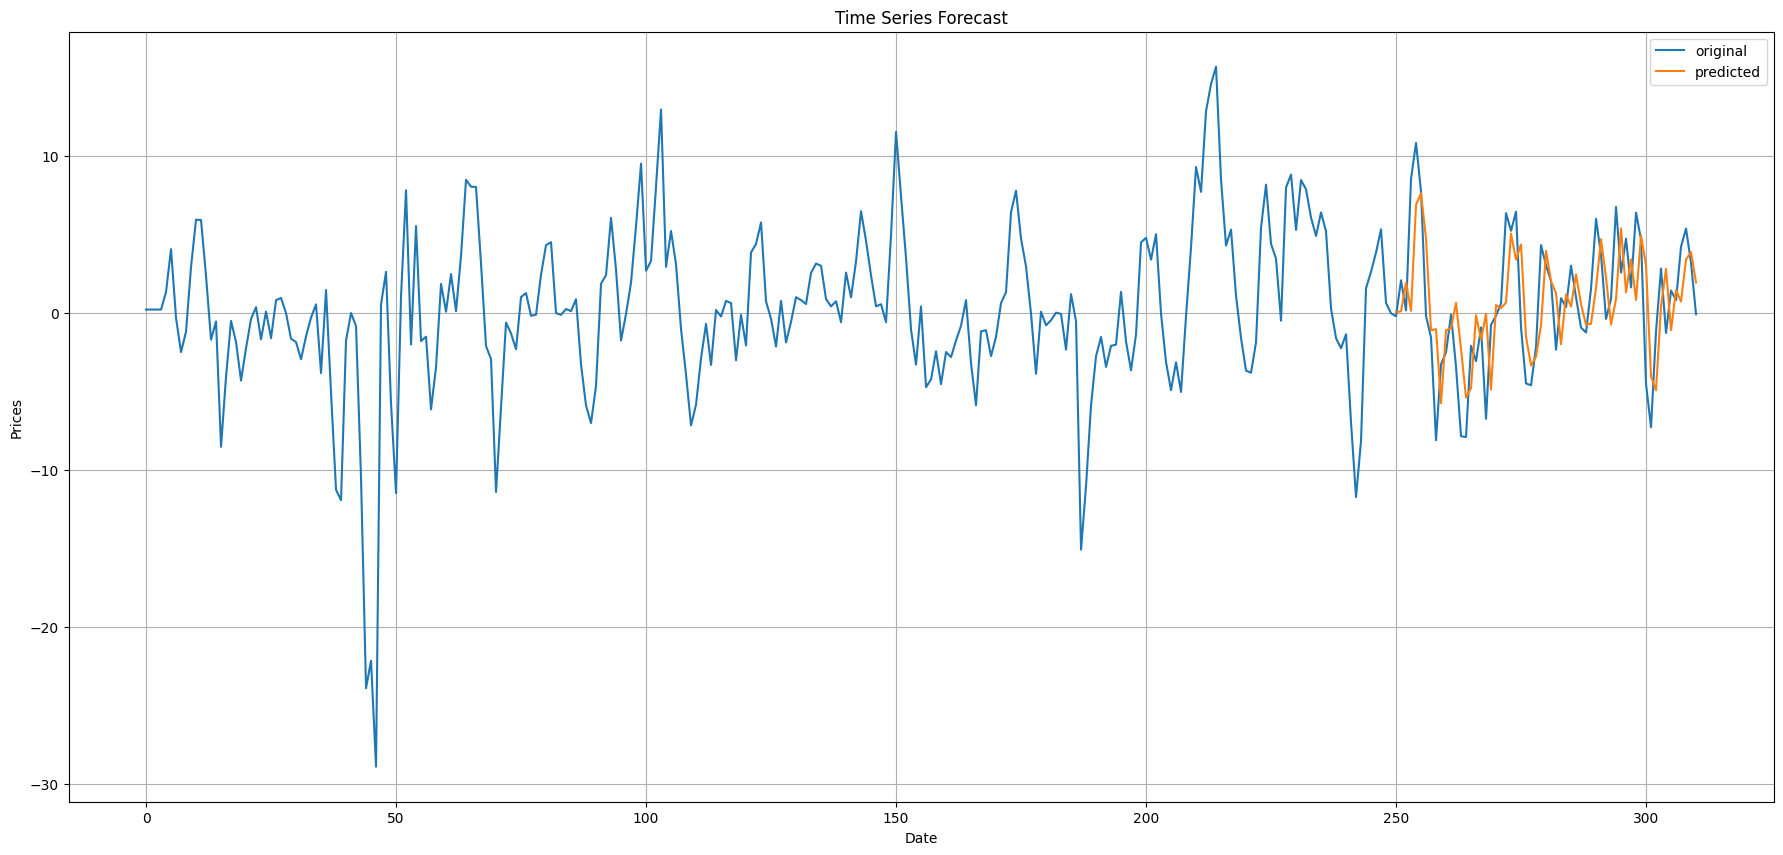

In [59]:

#test_data

print(model_fit.summary())

forecast = model_fit.predict(start=test_data_arima.index[0], end=test_data_arima.index[-1])

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(df['difference'].index, df['difference'],label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [60]:
## Lets use yahoo data

In [61]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'MSFT'

# Get data for the past year
start_date = '2018-01-01'
end_date = '2023-03-26'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

# Remove the time component from the Date column
tickerDf['Date'] = tickerDf.index.date
tickerDf.set_index(tickerDf['Date'],inplace=True)
# Print the modified DataFrame
tickerDf


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2018-01-02,80.907245,81.076330,80.315449,80.738159,22483800,0.0,0.0,2018-01-02
2018-01-03,80.841483,81.264201,80.756944,81.113899,26061400,0.0,0.0,2018-01-03
2018-01-04,81.339370,82.344495,81.320586,81.827843,21912000,0.0,0.0,2018-01-04
2018-01-05,82.344478,83.048999,82.128421,82.842339,23407100,0.0,0.0,2018-01-05
2018-01-08,82.851722,83.208684,82.288106,82.926872,22113000,0.0,0.0,2018-01-08
...,...,...,...,...,...,...,...,...
2023-03-20,276.980011,277.480011,269.850006,272.230011,43466600,0.0,0.0,2023-03-20
2023-03-21,274.880005,275.000000,269.519989,273.779999,34558700,0.0,0.0,2023-03-21
2023-03-22,273.399994,281.040009,272.179993,272.290009,34873300,0.0,0.0,2023-03-22


In [62]:
tickerDf_02 = tickerDf.copy()

<Figure size 640x480 with 0 Axes>

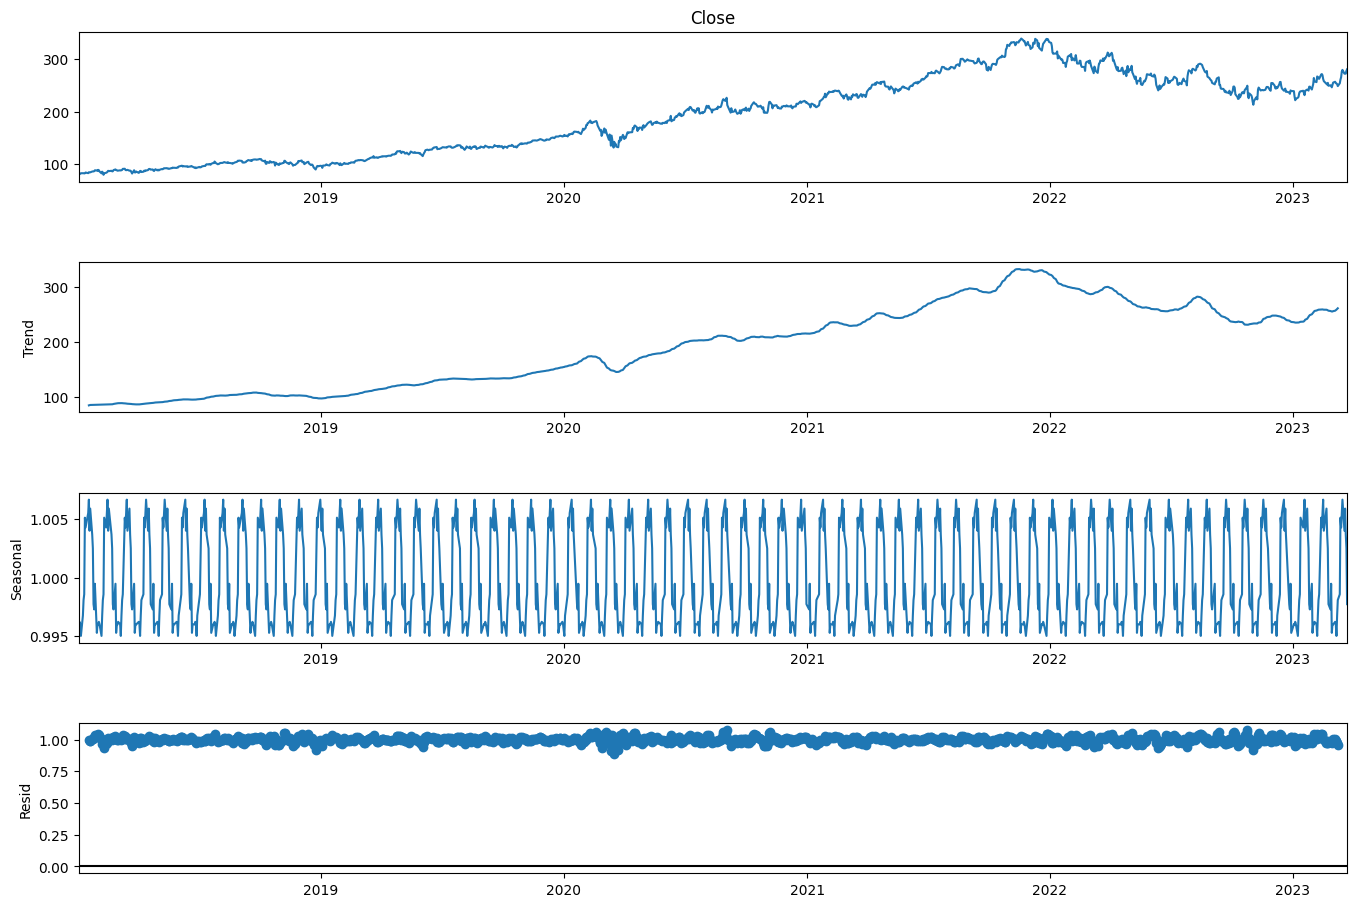

In [63]:
result = seasonal_decompose(tickerDf['Close'], model='multiplicative',period=20) 
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

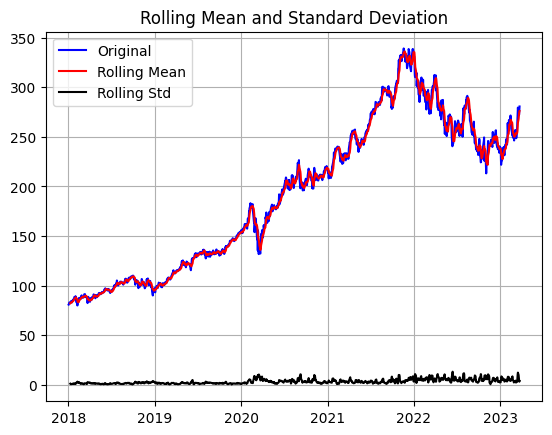

Results of dickey fuller test
Test Statistics                  -1.053288
p-value                           0.733336
No. of lags used                  9.000000
Number of observations used    1306.000000
critical value (1%)              -3.435367
critical value (5%)              -2.863756
critical value (10%)             -2.567950
dtype: float64


In [64]:
test_stationarity(tickerDf['Close'])

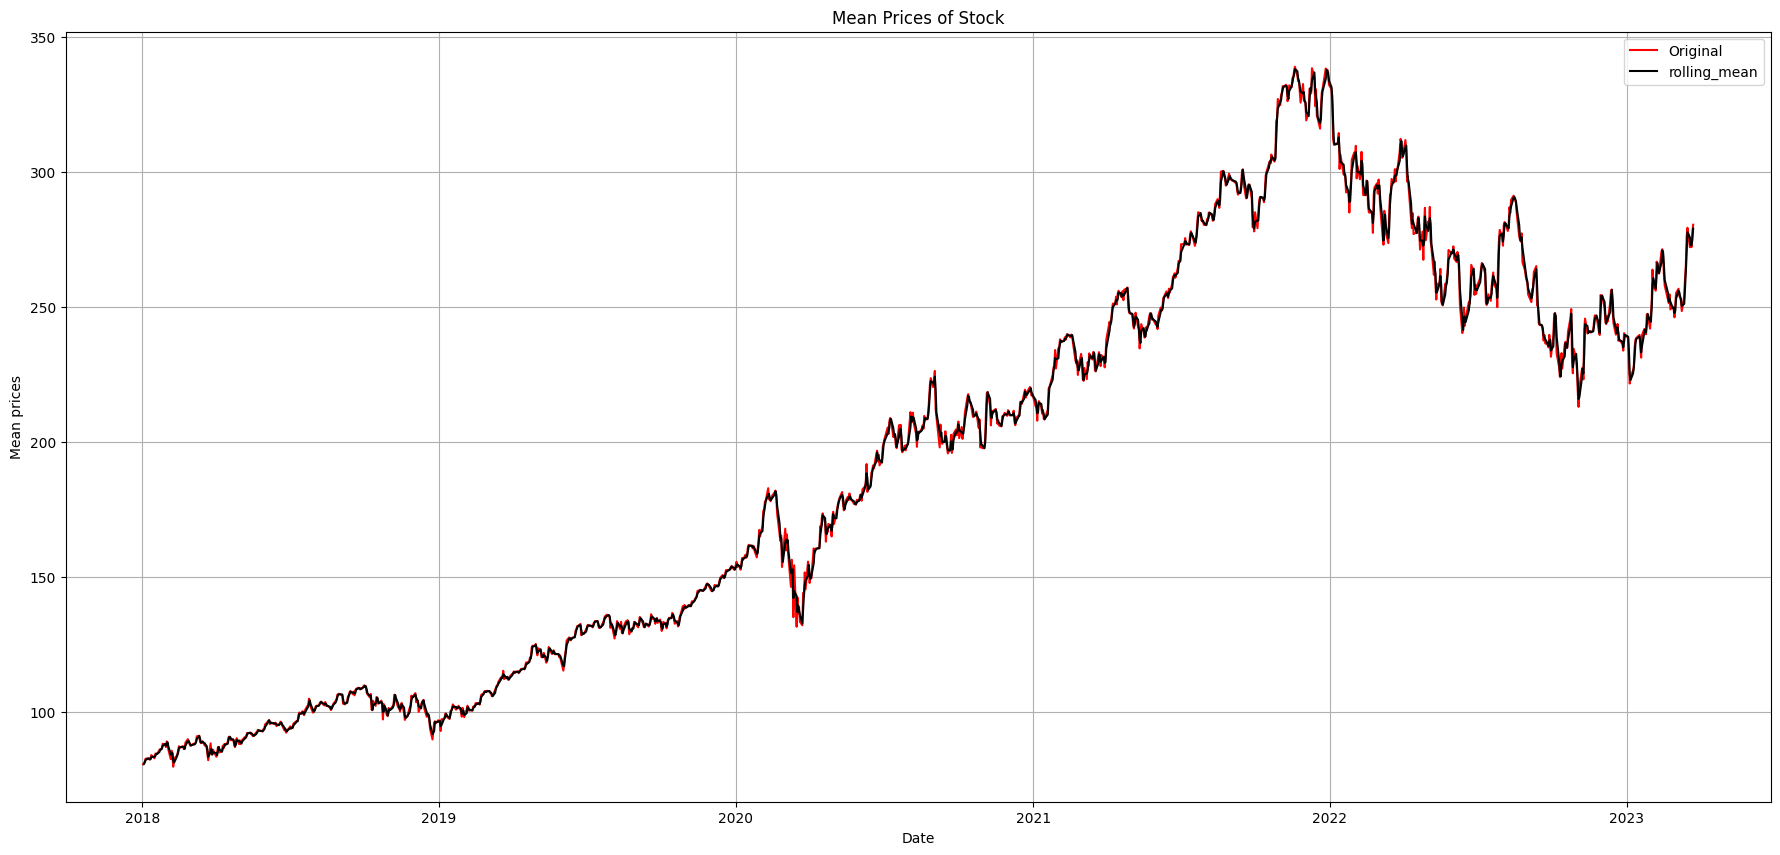

In [65]:
# Moving average method
moving_avg = tickerDf['Close'].rolling(2).mean()
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(tickerDf['Close'], color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "rolling_mean")
plt.title("Mean Prices of Stock")
plt.xlabel("Date")
plt.ylabel("Mean prices")
plt.legend()
plt.show()

In [66]:
ts_moving_avg_diff = tickerDf['Close'] - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

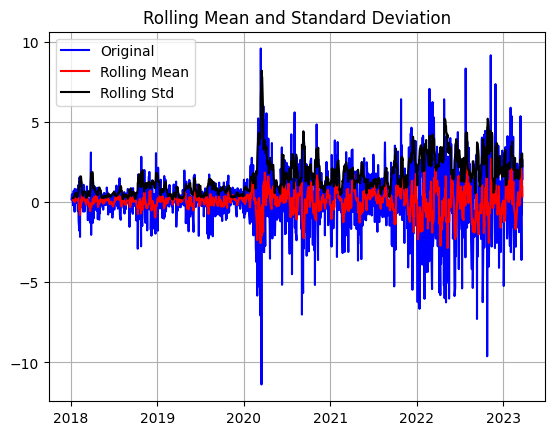

Results of dickey fuller test
Test Statistics               -1.183786e+01
p-value                        7.713922e-22
No. of lags used               8.000000e+00
Number of observations used    1.306000e+03
critical value (1%)           -3.435367e+00
critical value (5%)           -2.863756e+00
critical value (10%)          -2.567950e+00
dtype: float64


In [67]:
test_stationarity(ts_moving_avg_diff)

In [68]:
tickerDf['difference'] = ts_moving_avg_diff
tickerDf['difference'].fillna(tickerDf['difference'].mean(), inplace=True)
tickerDf['Date'] = tickerDf.index
tickerDf = tickerDf.reset_index(drop=True)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,difference
0,80.907245,81.076330,80.315449,80.738159,22483800,0.0,0.0,2018-01-02,0.075982
1,80.841483,81.264201,80.756944,81.113899,26061400,0.0,0.0,2018-01-03,0.187870
2,81.339370,82.344495,81.320586,81.827843,21912000,0.0,0.0,2018-01-04,0.356972
3,82.344478,83.048999,82.128421,82.842339,23407100,0.0,0.0,2018-01-05,0.507248
4,82.851722,83.208684,82.288106,82.926872,22113000,0.0,0.0,2018-01-08,0.042267
...,...,...,...,...,...,...,...,...,...
1311,276.980011,277.480011,269.850006,272.230011,43466600,0.0,0.0,2023-03-20,-3.599991
1312,274.880005,275.000000,269.519989,273.779999,34558700,0.0,0.0,2023-03-21,0.774994
1313,273.399994,281.040009,272.179993,272.290009,34873300,0.0,0.0,2023-03-22,-0.744995
1314,277.940002,281.059998,275.200012,277.660004,36610900,0.0,0.0,2023-03-23,2.684998


In [69]:
tickerDf[['difference', 'Date']][1200:]

,difference,Date
1200,-6.241722,2022-10-07
1201,-2.481781,2022-10-10
1202,-1.909821,2022-10-11
1203,0.169098,2022-10-12
1204,4.222504,2022-10-13
...,...,...
1311,-3.599991,2023-03-20
1312,0.774994,2023-03-21
1313,-0.744995,2023-03-22
1314,2.684998,2023-03-23


In [70]:
train_data_prophet_y = tickerDf[['difference', 'Date']][0:1200]
test_data_prophet_y = tickerDf[['difference', 'Date']][1200:]

train_data_prophet_y.rename(columns={"Date": "ds", "difference": "y"}, inplace=True)
test_data_prophet_y.rename(columns={"Date": "ds", "difference": "y"}, inplace=True)

test_data_prophet_y

,y,ds
1200,-6.241722,2022-10-07
1201,-2.481781,2022-10-10
1202,-1.909821,2022-10-11
1203,0.169098,2022-10-12
1204,4.222504,2022-10-13
...,...,...
1311,-3.599991,2023-03-20
1312,0.774994,2023-03-21
1313,-0.744995,2023-03-22
1314,2.684998,2023-03-23


In [71]:
Prophet = Prophet()
Prophet.fit(train_data_prophet_y)

16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
forecast = Prophet.predict(test_data_prophet_y[['ds']])

In [73]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-07,-0.016241,-2.361433,2.304579,-0.016241,-0.016241,0.131949,0.131949,0.131949,-0.006666,-0.006666,-0.006666,0.138615,0.138615,0.138615,0.0,0.0,0.0,0.115708
1,2022-10-10,-0.016602,-2.268279,2.251760,-0.016602,-0.016602,0.111975,0.111975,0.111975,-0.060236,-0.060236,-0.060236,0.172211,0.172211,0.172211,0.0,0.0,0.0,0.095373
2,2022-10-11,-0.016722,-2.305205,2.320411,-0.016722,-0.016722,0.101252,0.101252,0.101252,-0.079078,-0.079078,-0.079078,0.180330,0.180330,0.180330,0.0,0.0,0.0,0.084529
3,2022-10-12,-0.016843,-1.937701,2.756234,-0.016843,-0.016843,0.437847,0.437847,0.437847,0.250769,0.250769,0.250769,0.187078,0.187078,0.187078,0.0,0.0,0.0,0.421004
4,2022-10-13,-0.016963,-2.253561,2.212140,-0.016963,-0.016963,0.120848,0.120848,0.120848,-0.071742,-0.071742,-0.071742,0.192590,0.192590,0.192590,0.0,0.0,0.0,0.103885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2023-03-20,-0.035997,-2.326015,2.277576,-0.036685,-0.035328,0.032492,0.032492,0.032492,-0.060236,-0.060236,-0.060236,0.092728,0.092728,0.092728,0.0,0.0,0.0,-0.003505
112,2023-03-21,-0.036118,-2.361813,2.528387,-0.036818,-0.035435,0.027062,0.027062,0.027062,-0.079078,-0.079078,-0.079078,0.106140,0.106140,0.106140,0.0,0.0,0.0,-0.009056
113,2023-03-22,-0.036238,-1.885779,2.684841,-0.036949,-0.035546,0.369290,0.369290,0.369290,0.250769,0.250769,0.250769,0.118522,0.118522,0.118522,0.0,0.0,0.0,0.333052
114,2023-03-23,-0.036359,-2.375375,2.239942,-0.037077,-0.035657,0.058272,0.058272,0.058272,-0.071742,-0.071742,-0.071742,0.130014,0.130014,0.130014,0.0,0.0,0.0,0.021914


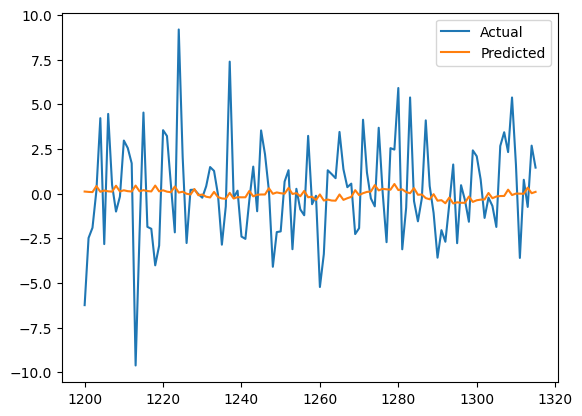

In [74]:
# visualize the predictions vs. the actual values
plt.plot(test_data_prophet_y.index, test_data_prophet_y['y'], label='Actual')
plt.plot(test_data_prophet_y.index, forecast['yhat'], label='Predicted')
plt.legend()
plt.show()


16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing


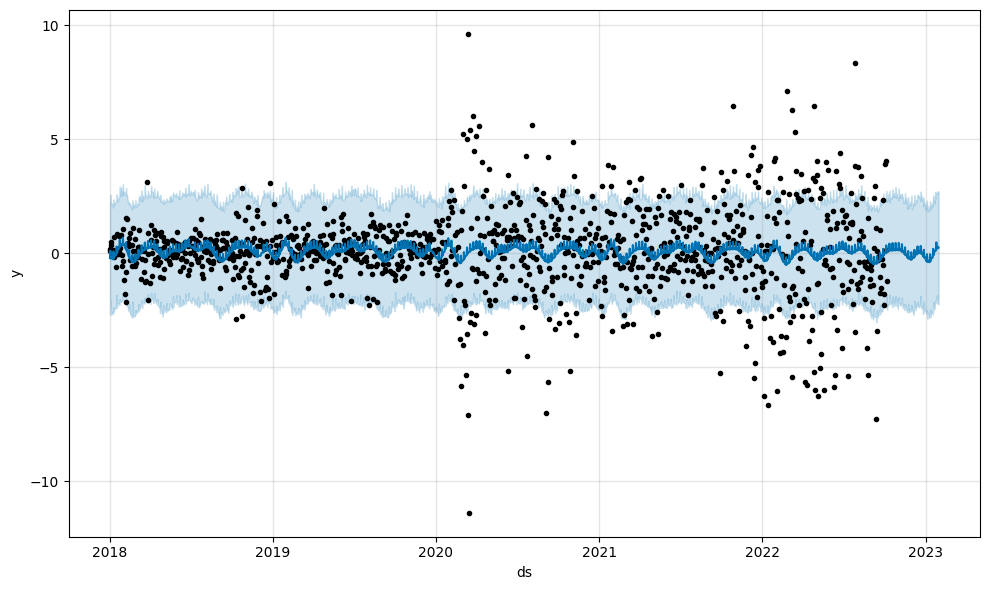

In [77]:

# Instantiate the Prophet class and fit it on the training data
model = Prophet()
model.fit(train_data_prophet_y)

# Create a new DataFrame with future dates
future = model.make_future_dataframe(periods=len(test_data_prophet_y))

# Generate forecasts for the future dates
forecast = model.predict(future)

# Plot the actual values and the forecasted values
fig = model.plot(forecast)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5493.174, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5480.784, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5480.457, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5482.177, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5482.344, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5482.809, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5479.933, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5493.181, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5481.497, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5481.765, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5480.330, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5480.992, Time=1.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.505 seconds
                               SARIMAX Results                                
Dep. Vari

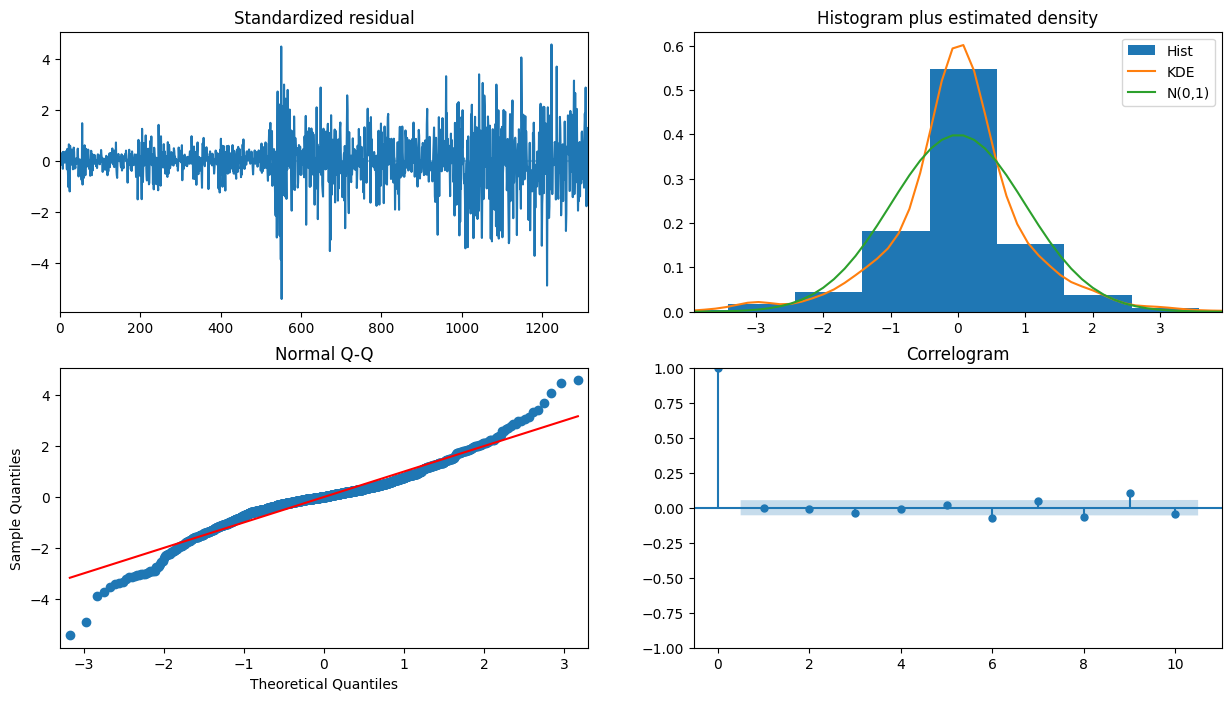

In [78]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(ts_moving_avg_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


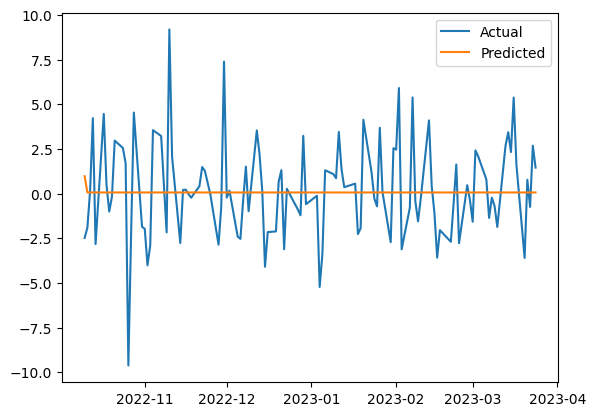

In [79]:
# split data into train and test sets


train_data_auto_y = ts_moving_avg_diff[:1200]
test_data_auto_y = ts_moving_avg_diff[1200:]

# fit the ARIMA model on the training data
model_autoARIMA.fit(train_data_auto_y)

# make predictions on the test data
predictions = model_autoARIMA.predict(n_periods=len(test_data_auto_y))

# visualize the predictions vs. the actual values
plt.plot(test_data_auto_y.index, test_data_auto_y.values, label='Actual')
plt.plot(test_data_auto_y.index, predictions, label='Predicted')
plt.legend()
plt.show()


C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


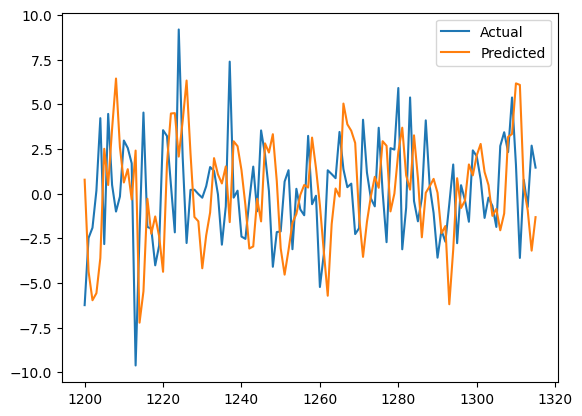

In [80]:

# fit an ARIMA model to the difference series
model = ARIMA(tickerDf['difference'], order=(9,4,1))
model_fit = model.fit()

# split data into train and test sets
train_data_arima = tickerDf['difference'][:1200]
test_data_arima = tickerDf['difference'][1200:]

# make predictions on the test data
start_idx = test_data_arima.index[0]  # get the start index of the test data
end_idx = test_data_arima.index[-1]  # get the end index of the test data
predictions = model_fit.predict(start=start_idx, end=end_idx)

# visualize the predictions vs. the actual values
plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(predictions.index, predictions.values, label='Predicted')
plt.legend()
plt.show()


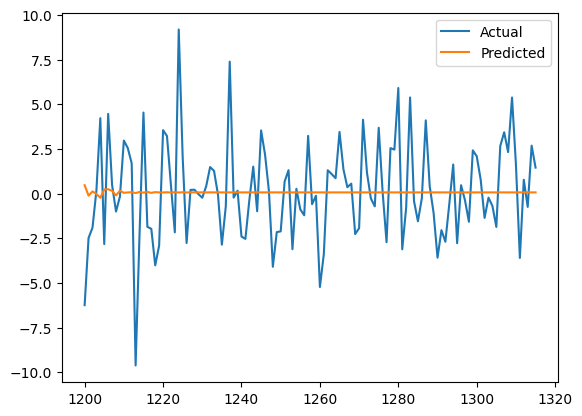

In [81]:
# split data into train and test sets
train_data_arima = tickerDf['difference'][:1200]
test_data_arima = tickerDf['difference'][1200:]

# fit an ARIMA model to the difference series
model = ARIMA(train_data_arima, order=(9,0,1))
model_fit = model.fit()



# make predictions on the test data
start_idx = test_data_arima.index[0]  # get the start index of the test data
end_idx = test_data_arima.index[-1]  # get the end index of the test data
predictions = model_fit.predict(start=start_idx, end=end_idx)

# visualize the predictions vs. the actual values
plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(predictions.index, predictions.values, label='Predicted')
plt.legend()
plt.show()


In [82]:
model = ARIMA(tickerDf['difference'], order=(5,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                 1316
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2731.192
Date:                Sat, 01 Apr 2023   AIC                           5478.383
Time:                        16:15:00   BIC                           5519.836
Sample:                             0   HQIC                          5493.928
                               - 1316                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8823      0.077    -11.389      0.000      -1.034      -0.730
ar.L2         -0.0990      0.028     -3.531      0.000      -0.154      -0.044
ar.L3         -0.0517      0.027     -1.889      0.0

C:\Users\abedq\anaconda3\envs\time2\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                 1316
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2731.192
Date:                Sat, 01 Apr 2023   AIC                           5478.383
Time:                        16:15:00   BIC                           5519.836
Sample:                             0   HQIC                          5493.928
                               - 1316                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8823      0.077    -11.389      0.000      -1.034      -0.730
ar.L2         -0.0990      0.028     -3.531      0.000      -0.154      -0.044
ar.L3         -0.0517      0.027     -1.889      0.0

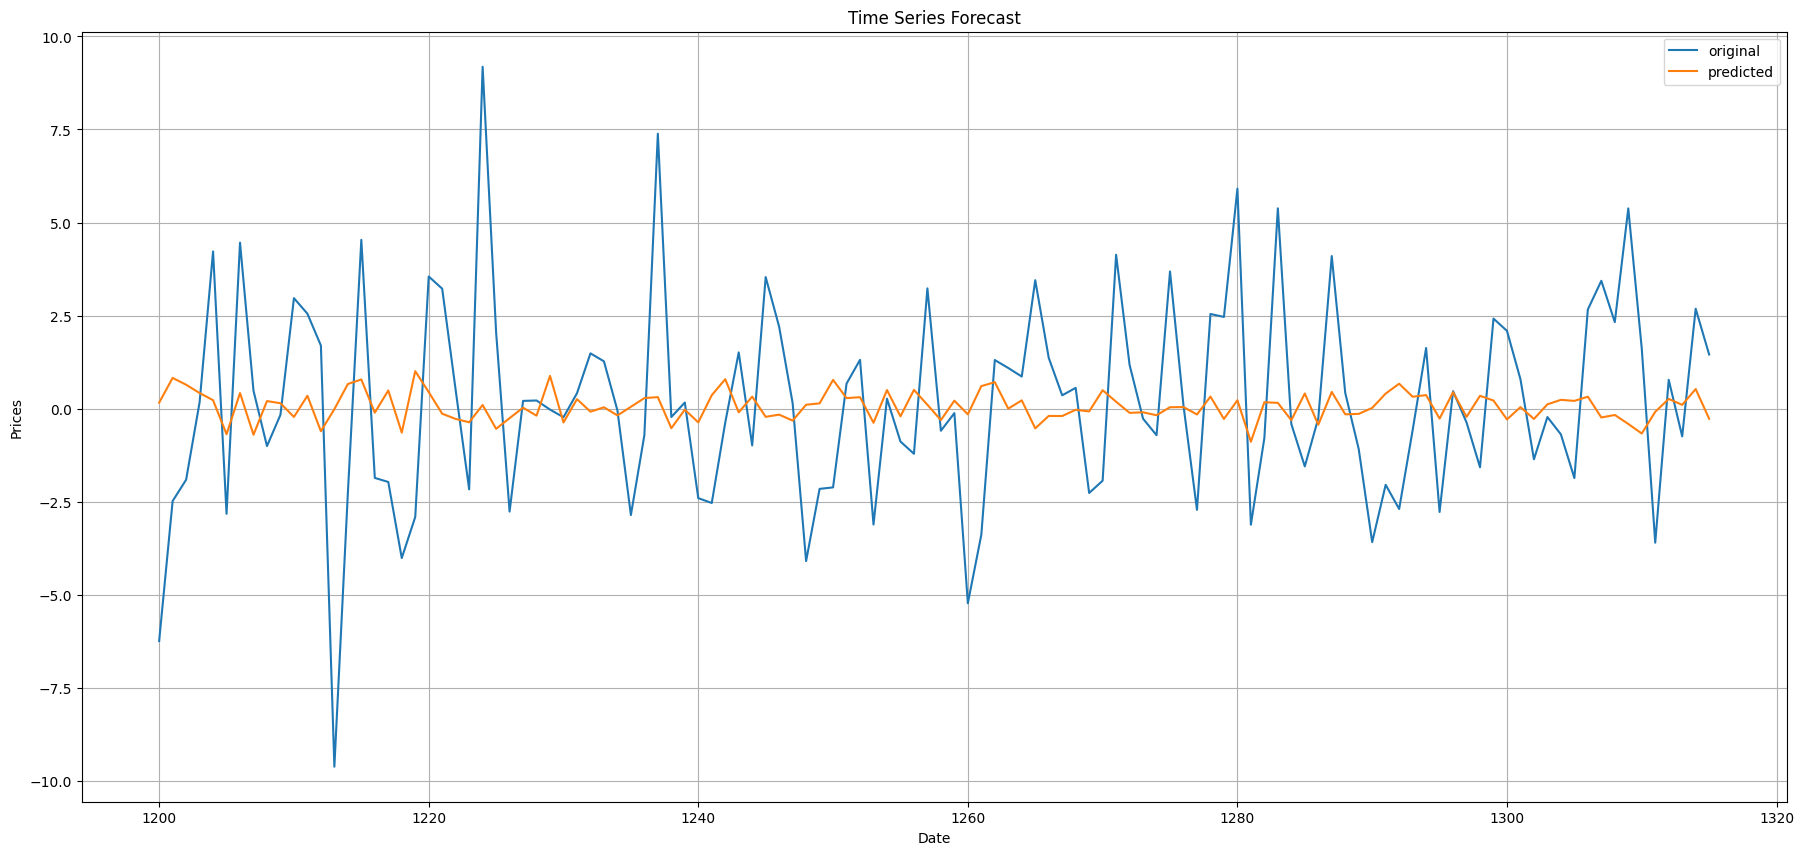

In [83]:
# predict
#test_data

print(fitted.summary())

forecast = fitted.predict(start=test_data_prophet_y.index[0], end=test_data_prophet_y.index[-1])

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(test_data_prophet_y['y'].index, test_data_prophet_y['y'],label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [96]:
#############
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [97]:
tickerDf_02

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2018-01-02,80.907245,81.076330,80.315449,80.738159,22483800,0.0,0.0,2018-01-02
2018-01-03,80.841483,81.264201,80.756944,81.113899,26061400,0.0,0.0,2018-01-03
2018-01-04,81.339370,82.344495,81.320586,81.827843,21912000,0.0,0.0,2018-01-04
2018-01-05,82.344478,83.048999,82.128421,82.842339,23407100,0.0,0.0,2018-01-05
2018-01-08,82.851722,83.208684,82.288106,82.926872,22113000,0.0,0.0,2018-01-08
...,...,...,...,...,...,...,...,...
2023-03-20,276.980011,277.480011,269.850006,272.230011,43466600,0.0,0.0,2023-03-20
2023-03-21,274.880005,275.000000,269.519989,273.779999,34558700,0.0,0.0,2023-03-21
2023-03-22,273.399994,281.040009,272.179993,272.290009,34873300,0.0,0.0,2023-03-22


In [99]:
tain_data = tickerDf_02[:1000]
test_data = tickerDf_02[1000:]
test_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2021-12-21,319.488653,323.876449,316.039669,323.441620,24740600,0.0,0.0,2021-12-21
2021-12-22,324.439697,329.687257,321.919693,329.282104,24831500,0.0,0.0,2021-12-22
2021-12-23,328.837387,332.434600,328.817633,330.754578,19617800,0.0,0.0,2021-12-23
2021-12-27,331.515511,338.452986,331.485865,338.423340,19947000,0.0,0.0,2021-12-27
2021-12-28,339.115110,339.767353,336.318400,337.237457,15661500,0.0,0.0,2021-12-28
...,...,...,...,...,...,...,...,...
2023-03-20,276.980011,277.480011,269.850006,272.230011,43466600,0.0,0.0,2023-03-20
2023-03-21,274.880005,275.000000,269.519989,273.779999,34558700,0.0,0.0,2023-03-21
2023-03-22,273.399994,281.040009,272.179993,272.290009,34873300,0.0,0.0,2023-03-22


In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_data = scaler.fit_transform(tain_data['Close'].values.reshape(-1, 1))
test_scaled_data = scaler.transform(test_data['Close'].values.reshape(-1, 1))


In [103]:

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i+window_size), 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 5
X_train_lstm, y_train_lstm = create_dataset(train_scaled_data, window_size)
X_test_lstm, y_test_lstm = create_dataset(test_scaled_data, window_size)


In [104]:
X_train_lstm.shape

(995, 5)

In [105]:
X_train_lstm.shape

(995, 5)

In [106]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [107]:
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=1)

y_pred = model.predict(X_test_lstm)
y_pred = scaler.inverse_transform(y_pred)
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))


Epoch 1/50
32/32 [==============================] - 7s 14ms/step - loss: 0.0433
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 4.7343e-04
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 4.0068e-04
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 4.3403e-04
Epoch 6/50
32/32 [==============================] - 0s 13ms/step - loss: 3.5536e-04
Epoch 7/50
32/32 [==============================] - 0s 14ms/step - loss: 3.4352e-04
Epoch 8/50
32/32 [==============================] - 0s 14ms/step - loss: 4.5995e-04
Epoch 9/50
32/32 [==============================] - 0s 14ms/step - loss: 3.3999e-04
Epoch 10/50
32/32 [==============================] - 0s 13ms/step - loss: 3.8401e-04
Epoch 11/50
32/32 [==============================] - 0s 13ms/step - loss: 3.8455e-04
Epoch 12/50
32/32 [==============================] - 0s 14ms/step - loss: 3.5671e-

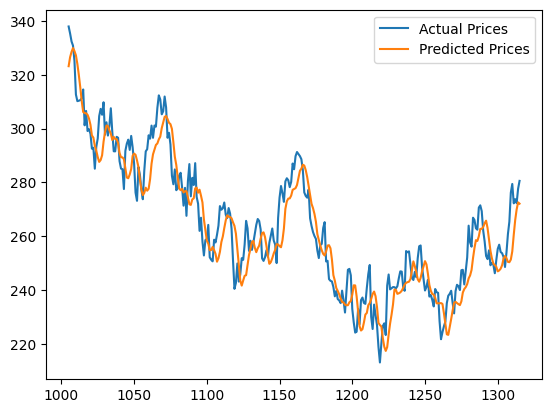

In [108]:
plt.plot(tickerDf.index[1000+window_size:], y_test_lstm, label='Actual Prices')
plt.plot(tickerDf.index[1000+window_size:], y_pred, label='Predicted Prices')
plt.legend()
plt.show()


In [119]:
def bollinger_bands(period,data):

    data['sma'] = data['predicted'].rolling(period).mean()
    data['std'] = data['predicted'].rolling(period).std()
    data['upper'] = data['sma']+(data['std']*2)
    data['lower'] = data['sma']-(data['std']*2)
    return data


def get_signal(data):
    buy_signal = []
    sell_signal = []
    hold_signal = []
    for i in range(len(data['predicted'])):
        if data['predicted'][i] > data['upper'][i]:
            buy_signal.append(np.nan)
            sell_signal.append(data['predicted'][i])
            hold_signal.append(np.nan)
        elif data['predicted'][i] < data['lower'][i]:
            buy_signal.append(data['predicted'][i])
            sell_signal.append(np.nan)
            hold_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            hold_signal.append(data['predicted'][i])
    return (buy_signal, sell_signal, hold_signal)


In [120]:
print(test_data.shape, y_pred.shape)

(311, 15) (311, 1)


In [114]:
test_data.drop(test_data.tail(5).index, inplace=True)
test_data.shape

C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\926333912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(test_data.tail(5).index, inplace=True)


(311, 8)

In [115]:
test_data['predicted'] = y_pred

C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\1875713467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = y_pred


In [116]:
bands_data=bollinger_bands(20,test_data)
bands_data.sort_index()

C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\2888406625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sma'] = data['predicted'].rolling(period).mean()
C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\2888406625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['std'] = data['predicted'].rolling(period).std()
C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\2888406625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,predicted,sma,std,upper,lower
Date,,,,,,,,,,,,,
2021-12-21,319.488653,323.876449,316.039669,323.441620,24740600,0.0,0.0,2021-12-21,323.170288,NaN,NaN,NaN,NaN
2021-12-22,324.439697,329.687257,321.919693,329.282104,24831500,0.0,0.0,2021-12-22,326.521088,NaN,NaN,NaN,NaN
2021-12-23,328.837387,332.434600,328.817633,330.754578,19617800,0.0,0.0,2021-12-23,328.497528,NaN,NaN,NaN,NaN
2021-12-27,331.515511,338.452986,331.485865,338.423340,19947000,0.0,0.0,2021-12-27,329.921906,NaN,NaN,NaN,NaN
2021-12-28,339.115110,339.767353,336.318400,337.237457,15661500,0.0,0.0,2021-12-28,328.785767,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,247.399994,257.910004,245.729996,253.919998,33339700,0.0,0.0,2023-03-13,260.476868,252.829296,5.285519,263.400334,242.258258
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,0.0,0.0,2023-03-14,265.991211,252.839585,5.312200,263.463986,242.215184
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,0.0,0.0,2023-03-15,269.961243,253.184281,6.165858,265.515997,240.852566


In [121]:
bands_data['buy'] = get_signal(bands_data)[0]
bands_data['sell'] = get_signal(bands_data)[1]
bands_data['hold'] = get_signal(bands_data)[2]

C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\3893618071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_data['buy'] = get_signal(bands_data)[0]
C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\3893618071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_data['sell'] = get_signal(bands_data)[1]
C:\Users\abedq\AppData\Local\Temp\ipykernel_4864\3893618071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

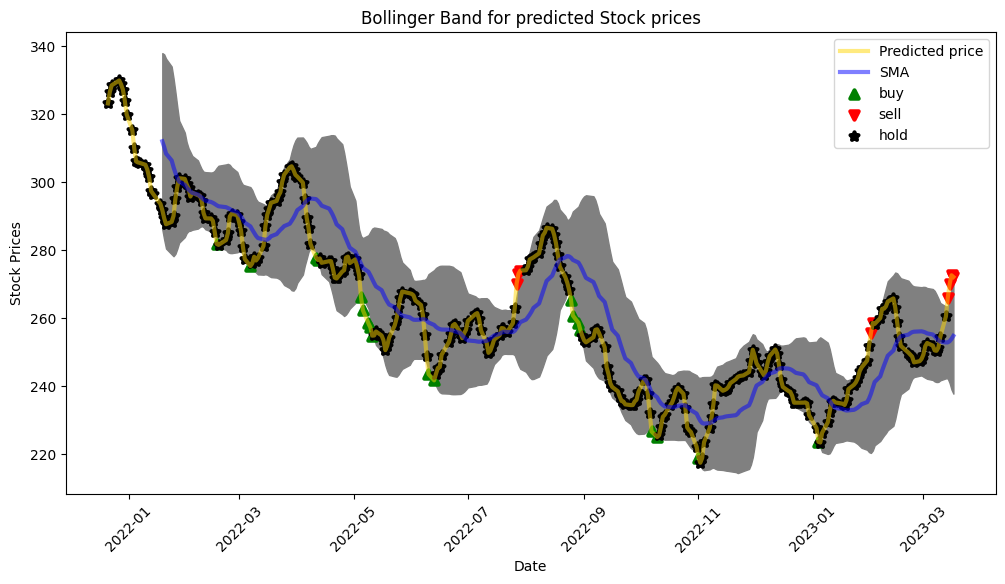

In [140]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
x_axis = bands_data.index
ax.fill_between(x_axis, bands_data['upper'],bands_data['lower'],color='grey')
ax.plot(x_axis, bands_data['predicted'],color = 'gold',lw=3,label='Predicted price', alpha = 0.5)
ax.plot(x_axis, bands_data['sma'],color = 'blue',lw=3,label='SMA', alpha = 0.5)
ax.scatter(x_axis, bands_data['buy'],color='green',lw=3,label='buy',marker='^', alpha = 1)
ax.scatter(x_axis, bands_data['sell'],color='red',lw=3,label='sell',marker='v', alpha = 1)
ax.scatter(x_axis, bands_data['hold'],color='black',lw=3,label='hold',marker='*', alpha = 1)
ax.set_title('Bollinger Band for predicted Stock prices')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Prices')
plt.xticks(rotation = 45)
ax.legend()
plt.show()

In [136]:
def find_mae(y_true, y_pred):
    """
    return the mean absolute error
    """
    return mean_absolute_error(y_true, y_pred)

In [137]:
find_mae(y_test_lstm, y_pred)

7.603668605399668

In [138]:
import tensorflow as tf
tf.keras.backend.clear_session()
